# <u>Trading System Development - Part 04</u>

### Strategy Rules
1. 1Hr Timeframe
2. 200 SMA
3. 10,3 Super Trend
4. Stop-Reverse Strategy
5. NIFTY index

#### LONG Entry Rules
1. 1Hr. Close > 200 SMA
2. Long signal on SuperTrend
3. (No ST long signals will be considered if close is below 200 SMA)

#### SHORT Entry Rules
1. 1Hr. Close < 200 SMA
2. Short signal on SuperTrend
3. (No ST short signals will be considered if close is above 200 SMA)



1. Optimization
2. 

# <u>AGENDA</u>

1. Live trade view
2. Optimization (problems and potential solutions)
3. Live Coding (On Solutions)
4. Previous Video Update
5. Faster SuperTrend Calculations (Numpy Arrays)


## <u>Problem Statements</u>

1. Profit not booking/Big Losses
2. Lower number of Trades
3. Low Win%
4. Long trade duration

## <u>Probable Solutions</u>

1. Reducing TF to increase trade frequency
2. Using signals to exit early/Book profits by applying targets - Median analysis
3. What if we exited on SuperTrend signal & ignore 200sma for exits  

In [1]:
#importing Libraries

import pandas as pd
import numpy as np
import datetime
import pandas_ta as ta

# <u>1. Data Cleaning</u>

In [2]:
#Add FilePath
raw_data = pd.read_csv('/Users/sunnykalyani/Downloads/nifty50.csv')

In [3]:
raw_data['date'] = raw_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
raw_data['time'] = raw_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time())
raw_data['datetime'] = raw_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [4]:
nifty_data = raw_data[['datetime','date','time','open','high','low','close']]

In [5]:
nifty_data.set_index('datetime',inplace=True, drop=True)

# <u>2. Data Resampling (1 Hr)</u>

In [6]:
def subDatetime(x):
    #Diwali Muraat Trading Hours(2015+11-11, 2016-10-30, 2017-10-9, 2018-11-7)(-30mins)
    if (x.date() in [
        datetime.date(2015,11,11),datetime.date(2016,10,30),datetime.date(2017,10,19),datetime.date(2018,11,7)
    ]):
        return x - datetime.timedelta(minutes=30)

    #2021 Feb NSE Down (Stopped at 10:09 started back at 15:45)(-45mins)
    elif (
        (x.date() == datetime.date(2021,2,24))
        and
        (x.time() > datetime.time(15,30)
        )):
        return x - datetime.timedelta(minutes=45)

    #All other times(-15mins)
    else:
        return x - datetime.timedelta(minutes=15)
        
def addDatetime(x):
    #Diwali Muraat Trading Hours(2015-11-11, 2016-10-30, 2017-10-9, 2018-11-7)(-30mins)
    if (x.date() in [
        datetime.date(2015,11,11),datetime.date(2016,10,30),datetime.date(2017,10,19),datetime.date(2018,11,7)
    ]):
        return x + datetime.timedelta(minutes=30)

    #2021 Feb NSE Down (Stopped at 10:09 started back at 15:45)(-45mins)
    elif (
        (x.date() == datetime.date(2021,2,24))
        and
        (x.time() > datetime.time(15,30)
        )):
        return x + datetime.timedelta(minutes=45)

    #All other times(+15mins)
    else:
        return x + datetime.timedelta(minutes=15)


In [7]:
nifty_data.reset_index(inplace=True)
nifty_data['datetime'] = nifty_data['datetime'].apply(subDatetime)
nifty_data.set_index('datetime',drop=True,inplace=True)

/var/folders/bk/x797cmpn36q8wvkjr3rfw85w0000gn/T/ipykernel_27742/1021208801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty_data['datetime'] = nifty_data['datetime'].apply(subDatetime)


In [8]:
nifty_data = nifty_data.resample('15T').agg({
    'date':'first',
    'time':'first',
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last'
})

In [9]:
nifty_data.reset_index(inplace=True)
nifty_data['datetime'] = nifty_data['datetime'].apply(addDatetime)

In [10]:
nifty_data.dropna(inplace=True)
nifty_data.reset_index(inplace=True, drop=True)

In [11]:
nifty_data

,datetime,date,time,open,high,low,close
0,2015-01-09 09:15:00,2015-01-09,09:15:00,8285.45,8303.00,8285.45,8294.15
1,2015-01-09 09:30:00,2015-01-09,09:30:00,8294.10,8295.75,8277.40,8285.55
2,2015-01-09 09:45:00,2015-01-09,09:45:00,8285.40,8287.65,8273.95,8282.00
3,2015-01-09 10:00:00,2015-01-09,10:00:00,8281.80,8287.35,8274.95,8281.55
4,2015-01-09 10:15:00,2015-01-09,10:15:00,8281.50,8291.10,8277.95,8290.45
...,...,...,...,...,...,...,...
55089,2023-12-15 14:15:00,2023-12-15,14:15:00,21331.95,21351.75,21328.15,21346.30
55090,2023-12-15 14:30:00,2023-12-15,14:30:00,21346.40,21364.65,21344.60,21357.95
55091,2023-12-15 14:45:00,2023-12-15,14:45:00,21356.90,21405.15,21356.45,21401.45
55092,2023-12-15 15:00:00,2023-12-15,15:00:00,21401.90,21458.40,21399.85,21458.40


# <u>3. Computing Indicators (200SMA & SuperTrend)</u>

#### 1. <u>Calculate Average True Range (ATR)</u>

        The Average True Range (ATR) is a measure of market volatility. 
        
        The true range for each period is the greatest of the following:
        1. The difference between the current high and the current low.
        2. The difference between the current high and the previous close.
        3. The difference between the current low and the previous close.



#### 2. <u>Calculate Basic Upper and Lower Bands</u>

        The basic upper and lower bands are calculated using the ATR and a multiplier (commonly set to 3).

        Basic Upper Band = ( (High + Low) / 2 ) + (Multiplier * ATR)
        Basic Lower Band = ( (High + Low) / 2 ) - (Multiplier * ATR)



#### 3. <u>Define Final Upper and Lower Bands</u>

        The final upper and lower bands are determined based on the previous period's bands and the Previous close.

        If the previous close is greater than the previous final upper band, then the current final upper band is the current basic upper band. 
        ELSE min(CurrentBasicUpperBand, PrevFinalUpperBand)
        
        
        If the previous close is less than the previous final lower band, then the current final lower band is the current basic lower band.
        ELSE max(CurrentBasicLowerBand, PrevFinalLowerBand)
        



#### 4. <u>Calculate SuperTrend</u>

####    (A) Check for First SuperTrend Value, based on first Crossover
        -If Previous close is less than previous final upper band, and current close is greater than current final upper band, So, current SuperTrend = Current FinalLowerBand
         BREAK to get first ST value
        -If Previous close is greater than previous final lower band, and current close is less than current final lower band, So, current SuperTrend = Current FinalUpperBand
         BREAK to get first ST value
               
####    (B) Check for subsequent SuperTrend Values        

        -If the previous period's SuperTrend is equal to the previous period's final upper band, and the current close is less than the current final upper band, then the current period's SuperTrend is the current final Upper band.
        -If the previous period's SuperTrend is equal to the previous period's final upper band, and the current close is greater than the current final upper band, then the current period's SuperTrend is the current final Lower band.

        -If the previous period's SuperTrend is equal to the previous period's final Lower band, and the current close is greater than the current final Lower band, then the current period's SuperTrend is the current final Lower band.
        -If the previous period's SuperTrend is equal to the previous period's final Lower band, and the current close is less than the current final lower band, then the current period's SuperTrend is the current final Upper band.

In [11]:
#Not used in this Backtest
#200 SMA
nifty_data['200sma'] = nifty_data['close'].rolling(window=200).mean()

In [12]:
def atr(data, period):
    df = data.copy()
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = abs(df['low'] - df['close'].shift(1))
    df['true_range'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    #df['atr'] = df['true_range'].rolling(window=period).mean()
    df['atr'] = df['true_range'].ewm(com=period, min_periods=period).mean()
    return df['atr']

def superTrend(data, period, multiplier):
    df = data.copy()
    
    #STEP 1
    df['atr'] = atr(df, period)

    #STEP 2
    df['B-UB'] = ((df.high + df.low)/2) + (multiplier * df.atr)
    df['B-LB'] = ((df.high + df.low)/2) - (multiplier * df.atr)

    #STEP 3
    df['F-UB'] = df['B-UB']
    df['F-LB'] = df['B-LB']

    for i in range(period,len(df)):
        if df.iloc[i-1]['close'] > df.iloc[i-1]['F-UB']:
            df.loc[i, 'F-UB'] = df.iloc[i]['B-UB']
        else:
            df.loc[i, 'F-UB'] = min(df.iloc[i]['B-UB'], df.iloc[i-1]['F-UB'])

    for i in range(period,len(df)):
        if df.iloc[i-1]['close'] < df.iloc[i-1]['F-LB']:
            df.loc[i, 'F-LB'] = df.iloc[i]['B-LB']
        else:
            df.loc[i, 'F-LB'] = max(df.iloc[i]['B-LB'], df.iloc[i-1]['F-LB'])

    #STEP 4
    df['supertrend'] = np.nan

    for y in range(period, len(df)):
        if (df.iloc[y-1]['close'] <= df.iloc[y-1]['F-UB']) & (df.iloc[y]['close'] > df.iloc[y]['F-UB']):
            df.loc[y, 'supertrend'] = df.iloc[y]['F-LB']
            break
        if (df.iloc[y-1]['close'] >= df.iloc[y-1]['F-LB']) & (df.iloc[y]['close'] < df.iloc[y]['F-LB']):
            df.loc[y, 'supertrend'] = df.iloc[y]['F-UB']
            break

    for i in range(y+1, len(df)):
        if (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-UB']) & (df.iloc[i]['close'] <= df.iloc[i]['F-UB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-UB']
        elif (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-UB']) & (df.iloc[i]['close'] >= df.iloc[i]['F-UB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-LB']
        elif (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-LB']) & (df.iloc[i]['close'] >= df.iloc[i]['F-LB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-LB']
        elif (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-LB']) & (df.iloc[i]['close'] <= df.iloc[i]['F-LB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-UB']

    return df['supertrend']

In [13]:
%%time
nifty_data['supertrend'] = superTrend(nifty_data, 10, 3)
nifty_data['200sma'] = nifty_data['200sma'].shift(1)
nifty_data['supertrend'] = nifty_data['supertrend'].shift(1)

CPU times: user 12.2 s, sys: 93.4 ms, total: 12.3 s
Wall time: 12.4 s


In [14]:
nifty_data.dropna(inplace=True)
nifty_data.reset_index(drop=True, inplace=True)

# <u>3(B). Faster SuperTrend Computation</u>

In [27]:
#Not used in this Backtest
#200 SMA
nifty_data['200sma'] = nifty_data['close'].rolling(window=200).mean()

In [12]:
#ATR optimised for np.array
#Notice we are not passing any DataFrame - high/low/close will be initialised in the main function
def atr_np(high, low, close, period):
    h_l = high - low
    h_pc = np.maximum(high - np.roll(close, 1), 0)  # Replaces shift
    l_pc = np.maximum(low - np.roll(close, 1), 0)

    true_range = np.maximum(h_l, h_pc, l_pc)
    atr = pd.Series(true_range).ewm(com=period, min_periods=period).mean().to_numpy()
    return atr

In [13]:
#To Optimize this more - instead of looping over len(data) We can create a np.array of index of data and loop over that

def superTrend_np(data, period, multiplier):
    high, low, close = data['high'].to_numpy(), data['low'].to_numpy(), data['close'].to_numpy()

    # Step 1: Calculate ATR
    atr = atr_np(high, low, close, period)
    data['atr'] = atr_np(high, low, close, period)

    # Step 2: Calculate Basic Upper and Lower Bands
    b_ub = ((high + low) / 2) + (multiplier * atr)
    b_lb = ((high + low) / 2) - (multiplier * atr)

    # Step 3: Initialize Final Upper and Lower Bands
    f_ub, f_lb = b_ub.copy(), b_lb.copy()

    # Loop for F-UB and F-LB
    for i in range(period, len(data)):
        f_ub[i] = b_ub[i] if close[i-1] > f_ub[i-1] else min(b_ub[i], f_ub[i-1])
        f_lb[i] = b_lb[i] if close[i-1] < f_lb[i-1] else max(b_lb[i], f_lb[i-1])

    # Step 4: Supertrend Calculation
    supertrend = np.full_like(close, np.nan)

    # Initial crossover
    for y in range(period, len(data)):
        if (close[y-1] <= f_ub[y-1]) and (close[y] > f_ub[y]):
            supertrend[y] = f_lb[y]
            break
        elif (close[y-1] >= f_lb[y-1]) and (close[y] < f_lb[y]):
            supertrend[y] = f_ub[y]
            break

    # Remaining Supertrend values
    for i in range(y+1, len(data)):
        if (supertrend[i-1] == f_ub[i-1]) and (close[i] <= f_ub[i]):
            supertrend[i] = f_ub[i]
        elif (supertrend[i-1] == f_ub[i-1]) and (close[i] > f_ub[i]):
            supertrend[i] = f_lb[i]
        elif (supertrend[i-1] == f_lb[i-1]) and (close[i] >= f_lb[i]):
            supertrend[i] = f_lb[i]
        elif (supertrend[i-1] == f_lb[i-1]) and (close[i] < f_lb[i]):
            supertrend[i] = f_ub[i]

    return supertrend


In [16]:
%%time
nifty_data['supertrend'] = superTrend_np(nifty_data, 10, 3)

CPU times: user 104 ms, sys: 22.4 ms, total: 126 ms
Wall time: 184 ms


In [17]:
nifty_data.dropna(inplace=True)
nifty_data.reset_index(drop=True, inplace=True)

In [18]:
#nifty_data['200sma'] = nifty_data['200sma'].shift(1)
nifty_data['supertrend'] = nifty_data['supertrend'].shift(1)

In [19]:
nifty_data

,datetime,date,time,open,high,low,close,atr,supertrend
0,2015-01-09 12:15:00,2015-01-09,12:15:00,8222.85,8226.90,8208.90,8214.70,20.079280,NaN
1,2015-01-09 12:30:00,2015-01-09,12:30:00,8214.85,8219.50,8198.40,8213.50,20.205243,8278.137840
2,2015-01-09 12:45:00,2015-01-09,12:45:00,8214.50,8270.40,8205.70,8265.85,25.523328,8269.565728
3,2015-01-09 13:00:00,2015-01-09,13:00:00,8265.80,8272.60,8245.85,8245.85,25.665863,8269.565728
4,2015-01-09 13:15:00,2015-01-09,13:15:00,8246.70,8249.45,8228.55,8242.15,25.125743,8269.565728
...,...,...,...,...,...,...,...,...,...
55077,2023-12-15 14:15:00,2023-12-15,14:15:00,21331.95,21351.75,21328.15,21346.30,24.320203,21279.705663
55078,2023-12-15 14:30:00,2023-12-15,14:30:00,21346.40,21364.65,21344.60,21357.95,23.932003,21279.705663
55079,2023-12-15 14:45:00,2023-12-15,14:45:00,21356.90,21405.15,21356.45,21401.45,26.183639,21282.828992
55080,2023-12-15 15:00:00,2023-12-15,15:00:00,21401.90,21458.40,21399.85,21458.40,29.126035,21302.249084


# <u>4. Generating Buy/Sell Signals</u>

In [20]:
nifty_data['buy_signals'] = 0
nifty_data['sell_signals'] = 0

nifty_data['buy_signals'] = np.where((nifty_data.close.shift(1) < nifty_data.supertrend.shift(1)) 
                                     & 
                                     (nifty_data.close > nifty_data.supertrend),
                                     1, 
                                     0)

nifty_data['sell_signals'] = np.where((nifty_data.close.shift(1) > nifty_data.supertrend.shift(1)) 
                                     & 
                                     (nifty_data.close < nifty_data.supertrend),
                                     -1, 
                                     0)

# <u>5. Backtesting and computing TradeLog</u>

In [21]:
nifty_data

,datetime,date,time,open,high,low,close,atr,supertrend,buy_signals,sell_signals
0,2015-01-09 12:15:00,2015-01-09,12:15:00,8222.85,8226.90,8208.90,8214.70,20.079280,NaN,0,0
1,2015-01-09 12:30:00,2015-01-09,12:30:00,8214.85,8219.50,8198.40,8213.50,20.205243,8278.137840,0,0
2,2015-01-09 12:45:00,2015-01-09,12:45:00,8214.50,8270.40,8205.70,8265.85,25.523328,8269.565728,0,0
3,2015-01-09 13:00:00,2015-01-09,13:00:00,8265.80,8272.60,8245.85,8245.85,25.665863,8269.565728,0,0
4,2015-01-09 13:15:00,2015-01-09,13:15:00,8246.70,8249.45,8228.55,8242.15,25.125743,8269.565728,0,0
...,...,...,...,...,...,...,...,...,...,...,...
55077,2023-12-15 14:15:00,2023-12-15,14:15:00,21331.95,21351.75,21328.15,21346.30,24.320203,21279.705663,0,0
55078,2023-12-15 14:30:00,2023-12-15,14:30:00,21346.40,21364.65,21344.60,21357.95,23.932003,21279.705663,0,0
55079,2023-12-15 14:45:00,2023-12-15,14:45:00,21356.90,21405.15,21356.45,21401.45,26.183639,21282.828992,0,0
55080,2023-12-15 15:00:00,2023-12-15,15:00:00,21401.90,21458.40,21399.85,21458.40,29.126035,21302.249084,0,0


In [22]:
in_trade = False
trade_log = []

In [23]:
for idx, row in nifty_data.iterrows():

    if not in_trade:
        if row.buy_signals == 1:
            in_trade = True
            trade_direction = 'LONG'
            entry_price = row.close
            entry_date = row.date
            entry_time = row.time
        elif row.sell_signals == -1:
            in_trade = True
            trade_direction = 'SHORT'
            entry_price = row.close
            entry_date = row.date
            entry_time = row.time

    elif in_trade:
        if trade_direction == 'LONG':
            if (nifty_data.iloc[idx-1].close > nifty_data.iloc[idx-1].supertrend) & (row.close < row.supertrend):
                exit_price = row.close
                exit_time = row.time
                exit_date = row.date
                trade_log.append({
                    'entry_date':entry_date,
                    'entry_time':entry_time,
                    'trade_direction':trade_direction,
                    'entry_price':entry_price,
                    'exit_date':exit_date,
                    'exit_time':exit_time,
                    'exit_price':exit_price,
                    'pnl':exit_price - entry_price
                })

                in_trade = False
                
                
        elif trade_direction == 'SHORT':
            if (nifty_data.iloc[idx-1].close < nifty_data.iloc[idx-1].supertrend) & (row.close > row.supertrend):
                exit_price = row.close
                exit_time = row.time
                exit_date = row.date
                trade_log.append({
                    'entry_date':entry_date,
                    'entry_time':entry_time,
                    'trade_direction':trade_direction,
                    'entry_price':entry_price,
                    'exit_date':exit_date,
                    'exit_time':exit_time,
                    'exit_price':exit_price,
                    'pnl':entry_price - exit_price
                })
    
                in_trade = False
    

In [24]:
len(trade_log)

811

In [25]:
trade_log_df = pd.DataFrame(trade_log)

In [26]:
trade_log_df.pnl.cumsum()

0         -9.05
1         35.20
2        386.90
3        301.55
4        209.50
         ...   
806    17607.00
807    17819.20
808    18545.50
809    18479.65
810    18454.00
Name: pnl, Length: 811, dtype: float64

<Axes: >

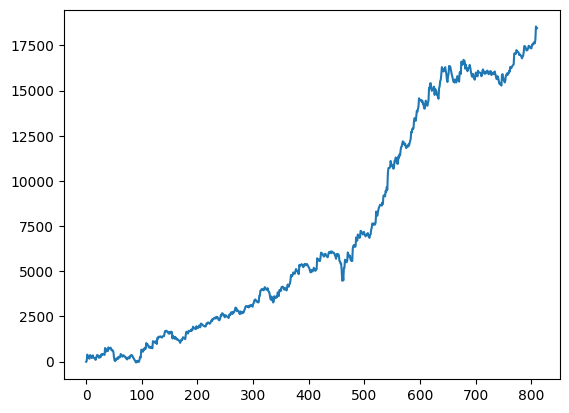

In [27]:
trade_log_df.pnl.cumsum().plot()

# <u>6. Computing Metrics</u>

In [28]:
pnl = trade_log_df['pnl']

In [29]:
pnl.cumsum()

0         -9.05
1         35.20
2        386.90
3        301.55
4        209.50
         ...   
806    17607.00
807    17819.20
808    18545.50
809    18479.65
810    18454.00
Name: pnl, Length: 811, dtype: float64

In [30]:
#Metrics
print(f'Total PnL(Points):    {round(sum(pnl),2)}')
print(f'Max Drawdown(Points): {round(min(pnl.cumsum() - pnl.cumsum().cummax()),2)}')
print(f'Win %:                {round(len(pnl[pnl > 0])/len(pnl)*100,2)}%')
print(f'Loss %:               {round(len(pnl[pnl < 0])/len(pnl)*100,2)}%')
print(f'Total Win Points:     {round(sum(pnl[pnl > 0]),2)}')
print(f'Total Loss Points:    {round(sum(pnl[pnl < 0]),2)}')
print(f'Calmar Ratio:         {-1*round(pnl.cumsum().iloc[-1]/min(pnl.cumsum() - pnl.cumsum().cummax()),2)}')

Total PnL(Points):    18454.0
Max Drawdown(Points): -1617.45
Win %:                45.99%
Loss %:               54.01%
Total Win Points:     49479.05
Total Loss Points:    -31025.05
Calmar Ratio:         11.41
